Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1.0}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2166
           1       0.88      0.97      0.92       111

    accuracy                           0.99      2277
   macro avg       0.94      0.98      0.96      2277
weighted avg       0.99      0.99      0.99      2277


ROC-AUC Score: 0.9991473467927762


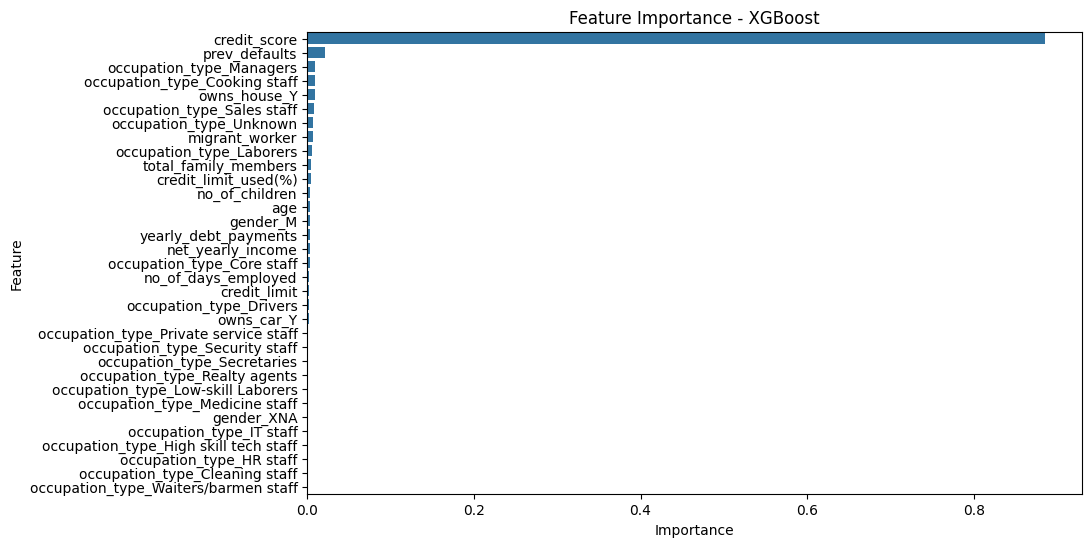

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE  # Handling class imbalance

# Load the dataset
data = pd.read_csv("test (1).csv")

# Drop non-relevant columns
data.drop(columns=["customer_id", "name"], inplace=True)

# Separate numerical and categorical columns
num_cols = data.select_dtypes(include=np.number).columns.tolist()
cat_cols = data.select_dtypes(include="object").columns.tolist()

# Fill missing values
data[num_cols] = data[num_cols].fillna(data[num_cols].median())  # Numerical columns with median
data[cat_cols] = data[cat_cols].fillna(data[cat_cols].mode().iloc[0])  # Categorical columns with mode

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)  # Avoid dummy variable trap

# Define features and target
X = data.drop(columns=["default_in_last_6months"])
y = data["default_in_last_6months"]

# Re-identify numerical columns after encoding
num_cols = X.select_dtypes(include=np.number).columns.tolist()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features only
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define the XGBoost model
model = XGBClassifier(random_state=42, eval_metric="logloss")

# Hyperparameter tuning using RandomizedSearchCV for efficiency
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
}

random_search = RandomizedSearchCV(
    estimator=model, param_distributions=param_dist,
    scoring="roc_auc", n_iter=20, cv=5, n_jobs=-1, random_state=42
)
random_search.fit(X_train_res, y_train_res)

# Best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Best Hyperparameters:", random_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

# Feature importance visualization
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance - XGBoost")
plt.show()
